In [1]:
import pandas as pd
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/twitch_data

/content/drive/MyDrive/twitch_data


In [4]:
%ls

1013713136.mp4                  sentiments   sentiments4
chat_df.csv                     sentiments1  sentiments5
chat_features_womeaningful.csv  sentiments2  video_df_merge.csv
data_vid_df_l.csv               sentiments3


In [19]:
chat_df = pd.read_csv('chat_df.csv',lineterminator='\n') 
chat_df.head()

,Unnamed: 0,video_url,timestamp,time_in_seconds,author_id,author_name,author_bio,messages
0,0,https://www.twitch.tv/videos/1619944979,1665353968134000,34.434,536714910,Mar0n1_,NaN,yo first
1,1,https://www.twitch.tv/videos/1619944979,1665353970195000,36.495,39378978,Azkii,"Hello, I am Azkii. Proud member of the Toad Sq...",Have good steam!
2,2,https://www.twitch.tv/videos/1619944979,1665353976374000,42.674,821199354,itzBaMofficial,I play Valorant at the moment,hi
3,3,https://www.twitch.tv/videos/1619944979,1665353978426000,44.726,519136869,youngmoneybandz,hey nerd,yoooo
4,4,https://www.twitch.tv/videos/1619944979,1665353978792000,45.092,477382692,shanenobi,NaN,!crosshair


In [20]:
#chat_df['video_id'] = chat_df['video_url'].str.strip().str[-10:]

In [21]:
# Well, you can even click on the url. That's neat.
print(chat_df.shape)
chat_df.groupby('video_url')['messages'].count().describe()

(226207, 8)


count       91.000000
mean      2485.780220
std       4476.282599
min          1.000000
25%        135.500000
50%        988.000000
75%       1970.500000
max      20000.000000
Name: messages, dtype: float64

In [22]:
video_df = pd.read_csv('video_df_merge.csv',index_col= 0)
print(video_df.columns)
video_df.head(2)

video_df.drop_duplicates(subset=['id'], keep='first',inplace=True)

Index(['id', 'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'muted_segments', 'duration_min', 'broadcaster_type',
       'broadcast_description', 'broadcaster_profile_image_url',
       'broadcaster_offline_image_url', 'broadcaster_created_at'],
      dtype='object')


## Basic chat features

#### num_messages, message_len, messages_per_min   
message_per_minute is a crude measure of 'roar of the corwd', when a bunch of messages appear like a waterfall. Because if there's no message in this minute, this minute is ignored when calculating this variable. 

In [23]:
# add a new column: length of messages with blankspace
chat_df['message_len'] = chat_df['messages'].str.len()
# basic chat features
chat_features_df = chat_df.groupby('video_url').agg({'messages':'count', # number of messages
                                  'message_len':'mean' # avearge message length
                                  }).reset_index()
chat_features_df.rename(columns={'messages':'num_messages'},inplace=True)

chat_features_df['video_id'] = chat_features_df['video_url'].str.strip().str[-10:]

In [24]:
# basic chat feature: number of messages per minute
# add a new column 
chat_df['time_in_minutes'] = chat_df['time_in_seconds'] // 60 # floor division
temp = chat_df.groupby(['video_url','time_in_minutes'])['messages'].count().reset_index()
# note that we hope to capture 'roar of a crowd' by this.
chat_features_df['num_messages_per_min'] = temp.groupby('video_url')['messages'].mean().values  #If no message this minute, this minute is ignored. 

In [25]:
chat_features_df.head(5)

,video_url,num_messages,message_len,video_id,num_messages_per_min
0,https://www.twitch.tv/videos/1013713136,1,14.000000,1013713136,1.000000
1,https://www.twitch.tv/videos/1573420701,15,27.800000,1573420701,2.500000
2,https://www.twitch.tv/videos/1575346830,24,37.375000,1575346830,1.600000
3,https://www.twitch.tv/videos/1577479493,10,33.200000,1577479493,1.666667
4,https://www.twitch.tv/videos/1578211985,68,24.985294,1578211985,3.777778


In [26]:
## basic chat feature: number of avg_messages_per_minute
# merge in some video_level variables
variables = ['id','user_id','user_name','duration_min','created_at','title','view_count','broadcaster_type','broadcast_description','broadcaster_created_at']
chat_features_df = pd.merge(chat_features_df, video_df[variables], how="left", left_on='video_id',right_on = 'id')
chat_features_df.drop('id', axis=1, inplace=True)  
# average number of messages per minute
chat_features_df['avg_messages_per_min'] = chat_features_df['num_messages'] / chat_features_df['duration_min']

In [27]:
chat_features_df[chat_features_df['video_url'].duplicated()]

,video_url,num_messages,message_len,video_id,num_messages_per_min,user_id,user_name,duration_min,created_at,title,view_count,broadcaster_type,broadcast_description,broadcaster_created_at,avg_messages_per_min


In [28]:
print(chat_features_df.columns)
chat_features_df.head(5)

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'user_name', 'duration_min',
       'created_at', 'title', 'view_count', 'broadcaster_type',
       'broadcast_description', 'broadcaster_created_at',
       'avg_messages_per_min'],
      dtype='object')


,video_url,num_messages,message_len,video_id,num_messages_per_min,user_id,user_name,duration_min,created_at,title,view_count,broadcaster_type,broadcast_description,broadcaster_created_at,avg_messages_per_min
0,https://www.twitch.tv/videos/1013713136,1,14.000000,1013713136,1.000000,448563316,VNCEOfficial,0.483333,2021-05-07 00:18:24+00:00,I was just trying to boogy a little...,4645.0,affiliate,WE LOVE GOOD VIBES BABY | SMOOCHES!!!!,2019-07-16T00:09:18Z,2.068966
1,https://www.twitch.tv/videos/1573420701,15,27.800000,1573420701,2.500000,229285909,AkzOnTop,14.333333,2022-08-26 20:42:52+00:00,Retired Overwatch pro is Vibin',13.0,affiliate,The names AkzOnTop. WE GET LIT IN HEREEE HIT T...,2018-06-07T00:53:11Z,1.046512
2,https://www.twitch.tv/videos/1575346830,24,37.375000,1575346830,1.600000,229285909,AkzOnTop,230.466667,2022-08-28 19:26:01+00:00,Retired Overwatch pro is Vibin',13.0,affiliate,The names AkzOnTop. WE GET LIT IN HEREEE HIT T...,2018-06-07T00:53:11Z,0.104137
3,https://www.twitch.tv/videos/1577479493,10,33.200000,1577479493,1.666667,229285909,AkzOnTop,35.033333,2022-08-31 01:14:20+00:00,Fortnite Pro plays Late game and Creative,12.0,affiliate,The names AkzOnTop. WE GET LIT IN HEREEE HIT T...,2018-06-07T00:53:11Z,0.285442
4,https://www.twitch.tv/videos/1578211985,68,24.985294,1578211985,3.777778,229285909,AkzOnTop,23.500000,2022-08-31 21:35:50+00:00,EX FORTNITE PRO LEANRS TO BECOME A CREATIVE WA...,10.0,affiliate,The names AkzOnTop. WE GET LIT IN HEREEE HIT T...,2018-06-07T00:53:11Z,2.893617


In [30]:
print(chat_features_df['video_url'].nunique())
print(chat_features_df['user_id'].nunique())

91
12


In [16]:
chat_features_df['video_url'][25:30]

25    https://www.twitch.tv/videos/1604098127
26    https://www.twitch.tv/videos/1604165847
27    https://www.twitch.tv/videos/1604458780
28    https://www.twitch.tv/videos/1604733184
29    https://www.twitch.tv/videos/1604878671
Name: video_url, dtype: object

In [31]:
chat_features_df.user_name.unique()

array(['VNCEOfficial', 'AkzOnTop', 'PatProzyy', 'prxd4v41', 'Methodz',
       'General_Mars', 'Rainbow6', 'SypherPK', 'iiTzTimmy',
       'moistcr1tikal', 'Murda10k', 'zackrawrr'], dtype=object)

#### Sentiments: sentiment_positive_percent,	sentiment_score  
Negative ones may affect the streamers' emotions, motivations, or perceived workload, sth like that.

In [ ]:
## sentiments:
## demo: https://colab.research.google.com/drive/1G4nvWf6NtytiEyiIkYxs03nno5ZupIJn?usp=sharing#scrollTo=e_puNMeUsx2p
## the post: https://huggingface.co/blog/sentiment-analysis-python#2-how-to-use-pre-trained-sentiment-analysis-models-with-python
#!pip install -q transformers
#!pip3 install emoji

     |████████████████████████████████| 5.3 MB 14.1 MB/s 
     |████████████████████████████████| 7.6 MB 42.6 MB/s 
     |████████████████████████████████| 163 kB 56.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 216 kB 13.4 MB/s 
  Created wheel for emoji: filename=emoji-2.1.0-py3-none-any.whl size=212392 sha256=efcb22304462114e7c4292e10cb7dc90237e2dc773c7ef184ec4e6efa11d42ce
  Stored in directory: /root/.cache/pip/wheels/77/75/99/51c2a119f4cfd3af7b49cc57e4f737bed7e40b348a85d82804
Successfully built emoji


In [ ]:
# Using pipeline class to make predictions from models available in the Hub in an easy way 
#from transformers import pipeline
#sentiment_pipeline = pipeline("sentiment-analysis") #default:bert

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.


Downloading:   0%|          | 0.00/629 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

In [ ]:
import pickle

In [ ]:
#data_training_list = chat_df['clean_messages'][150000:200000].tolist()
#sentiment_output = sentiment_pipeline(data_training_list)


#with open('sentiments4', 'wb') as fp:
#    pickle.dump(sentiment_output, fp)

In [ ]:
#data_training_list = chat_df['clean_messages'][200000:226206].tolist()
#sentiment_output = sentiment_pipeline(data_training_list)

#import pickle

#with open('sentiments5', 'wb') as fp:
#    pickle.dump(sentiment_output, fp)

In [ ]:
# This is stupid, but somehow my while loop and append gives me memory error
with open ('sentiments1', 'rb') as fp:
      sentiment1 = pickle.load(fp)

with open ('sentiments2', 'rb') as fp:
      sentiment2 = pickle.load(fp)

with open ('sentiments3', 'rb') as fp:
      sentiment3 = pickle.load(fp)

with open ('sentiments4', 'rb') as fp:
      sentiment4 = pickle.load(fp)

with open ('sentiments5', 'rb') as fp:
      sentiment5 = pickle.load(fp)

#i = 0
#file_list = ['sentiments1','sentiments2','sentiments3','sentiments4','sentiments5']
#sentiment = []
#while i <2:
#    with open (file_list[i], 'rb') as fp:
#      temp = pickle.load(fp)
#      sentiment.append(temp)

sentiment = sentiment1 + sentiment2 + sentiment3 +sentiment4 + sentiment5
sentiment.append('na')

print(len(chat_df))
print(len(sentiment))
sentiment[:5]

226207
226207


[{'label': 'POSITIVE', 'score': 0.9983066320419312},
 {'label': 'POSITIVE', 'score': 0.999859094619751},
 {'label': 'POSITIVE', 'score': 0.9983267188072205},
 {'label': 'NEGATIVE', 'score': 0.5072906017303467},
 {'label': 'POSITIVE', 'score': 0.9985467791557312}]

In [ ]:
chat_df['sentiment'] = sentiment
temp = chat_df['sentiment'].apply(pd.Series).reset_index()
chat_df = pd.concat([chat_df, temp], axis=1)

chat_df.rename(columns={'label':'sentiment_label',
                        'score':'sentiment_score'},inplace=True)

chat_df['sentiment_label_dummy']= np.where(chat_df['sentiment_label'] == 'POSITIVE',1,0)

In [ ]:
# basic features
chat_features_df['sentiment_positive_percent'] = chat_df.groupby(['video_url'])['sentiment_label_dummy'].mean().values
chat_features_df['sentiment_score'] = chat_df.groupby(['video_url'])['sentiment_score'].mean().values

In [ ]:
#chat_features_df.to_csv('chat_features_womeaningful.csv')

In [ ]:
#### Meaningful messages

## Ignore the wordcloud and LDA! Jump to Exploration part!

## Pre-processing and wordcloud

In [ ]:
# packages to process the message text
!pip3 install texthero
!pip3 install sweetviz
!pip install -U spacy

import texthero as hero
import sweetviz as sv

In [ ]:
# text preprocessing
from texthero import preprocessing

# create a custom pipeline to preprocess the raw text
custom_pipeline = [preprocessing.fillna
                   , preprocessing.lowercase
                   , preprocessing.remove_digits
                   , preprocessing.remove_punctuation
                   , preprocessing.remove_diacritics
                   , preprocessing.remove_stopwords]

chat_df['clean_messages']= hero.clean(chat_df['messages'], pipeline = custom_pipeline)

In [ ]:
# Custom STOPWORDS removal -- Need to think about this.Could use the cloud as below 
from texthero import stopwords
default_stopwords = stopwords.DEFAULT
custom_stopwords = default_stopwords.union(set(['yo','play',"twitch","make", "use", "thank", "content", "good", "use",
                                                "think", "need", "harrisheller", "like", "stream",
                                               "kekw","catjam","tim","timthetatman","tatkevinh",
                                               "wipz","docspin","pog","tatlove","lol","lul","omegalul",
                                               "biblethump","clap","tathypers","pepeja","kappa","tattopd","ppsmoke",
                                               "pepelaugh","gopackgo","gachihyper","tatkevinh", "wipz",
                                               "pausechamp","yep","lmao","jack","lulw","monkaw","kreygasm",
                                               "pepega","peped","foxsalt","pogchamp","xqcn","get","back",
                                               "tattuff","tatfat","tatpumpkin","lmao","sadge","sippy",
                                               "pogu","poggers","consolecd","widepeepohappy","pogu","tategg2",
                                               "modcheck","timmy","tathmm","tats","got","com","babyrage",
                                               "xqcp","tatw","pokiw","know", "thats","pepocd","tatafk",
                                               "4weird","tatkkevin", "tatblanket","tatglam","tategg1","wutface",
                                               "blobdance", "kapp","tatbruh","kappapride","facebaby","xqc",
                                               "xqcm","bora","hyperclap","tatlit","5head","gachibass", "go", "ur",
                                                "yes","going","would","im","oh","dez","taty","tk","u","sg", "dont",
                                                "hey","hf","look","anita","anitaheart","leeper","anitahey",
                                                "anitadab","anitadoubt","anitahands", "anitalul","anitapog","anitasword",
                                                "anitaprime","anitafeels","residentsleeper","anitapride","anital",
                                                "anitabiscuit", "thing","widepeeposad","anitahype","among", "lesbianpride",
                                                "heyguys","seemsgood","notlikethis","hi","also","much","yeah",'http'
                                               ])) ## Add as per requirement

# data = hero.remove_stopwords(data, default_stopwords)
chat_df['clean_messages_custom'] = hero.remove_stopwords(chat_df['clean_messages'], custom_stopwords)

In [ ]:
chat_df[['messages','clean_messages','clean_messages_custom']].head()

,messages,clean_messages,clean_messages_custom
0,yo first,yo first,first
1,Have good steam!,good steam,steam
2,hi,hi,
3,yoooo,yoooo,yoooo
4,!crosshair,crosshair,crosshair


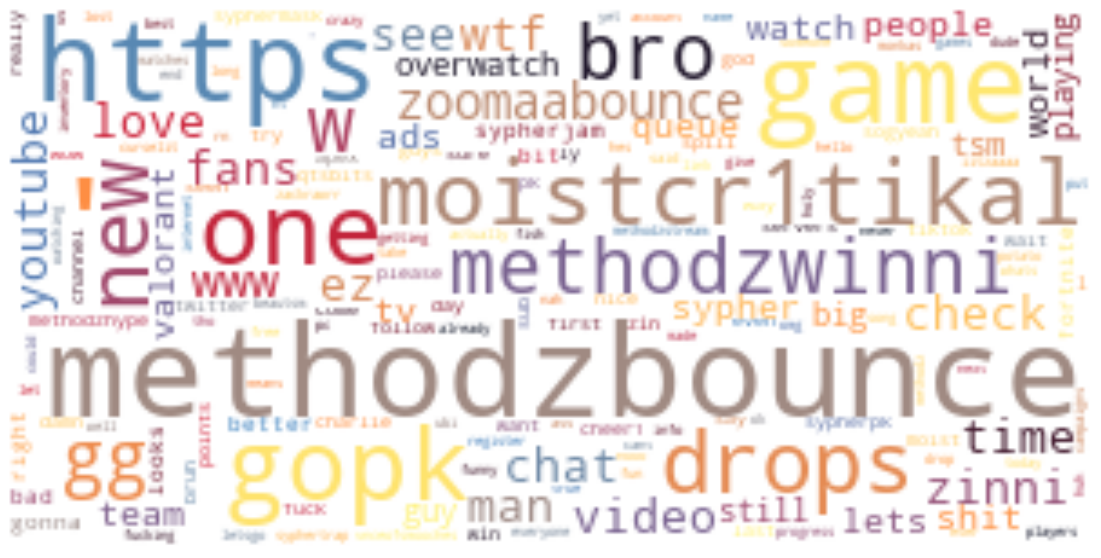

In [ ]:
# wordcloud. Well this is not so helpful
hero.visualization.wordcloud(chat_df['clean_messages_custom'], font_path = None, width = 300, height = 150, max_words=200, 
                             mask=None, contour_width=0, 
                             contour_color='PAPAYAWHIP', background_color='WHITE', 
                             relative_scaling='auto', colormap=None, return_figure=False)

## LDA - Topic as features 

In [ ]:
chat_df.isnull().sum()

Unnamed: 0                    0
video_url                     0
timestamp                     0
time_in_seconds               1
author_id                     1
author_name                   1
author_bio               121141
messages                      2
clean_messages                0
clean_messages_custom         0
dtype: int64

In [ ]:
chat_by_vid_df = chat_df.groupby(['video_url'], as_index = False).agg({'author_id': 'count','clean_messages_custom': ' '.join})
chat_by_vid_df.head()

,video_url,author_id,clean_messages_custom
0,https://www.twitch.tv/videos/1013713136,1,und das heisst
1,https://www.twitch.tv/videos/1573420701,15,fridayeu live streaming overwatch retired ...
2,https://www.twitch.tv/videos/1575346830,24,fridayeu live streaming fortnite retired f...
3,https://www.twitch.tv/videos/1577479493,10,fridayeu live streaming fortnite fortnite ...
4,https://www.twitch.tv/videos/1578211985,68,fridayeu live streaming fortnite ex fortni...


In [ ]:
# Try LDA first?
import gensim

# Tokenize
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(chat_by_vid_df['clean_messages_custom']))

print(data_words[:5])

[['und', 'das', 'heisst'], ['fridayeu', 'live', 'streaming', 'overwatch', 'retired', 'overwatch', 'pro', 'vibin', 'yooo', 'apex', 'zak', 'overwatch', 'cross', 'platform', 'psn', 'account', 'send', 'snap', 'nahh', 'new', 'ps', 'sym', 'enjoying', 'consider', 'hitting', 'follow', 'button', 'yooo', 'akz', 'deactivate', 'primary', 'ps', 'nahhh', 'overwatch', 'activated', 'primary', 'ps', 'snm', 'follow', 'twitter', 'fridayeu', 'jump', 'mins', 'akz'], ['fridayeu', 'live', 'streaming', 'fortnite', 'retired', 'fortnite', 'pro', 'vibin', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'corgo', 'toch', 'cheered', 'bits', 'cutie', 'ellejjlove', 'alright', 'havin', 'summer', 'traveling', 'drinking', 'concerts', 'beach', 'parties', 'enjoying', 'consider', 'hitting', 'follow', 'button', 'shat', 'omds', 'knocked', 'fuck', 'shit', 'gameplay', 'take', 'shit', 'airwaves', 'classic',

In [ ]:
import spacy

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append(" ".join([token.lemma_ if token.lemma_ not in ['-PRON-'] else '' for token in doc if token.pos_ in allowed_postags]))
    return texts_out

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only Noun, Adjective, Verb, Adverb
data_lemmatized = lemmatization(data_words, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:5])

['und heisst', 'live streaming overwatch retire overwatch pro vibin platform account send enjoy consider hit follow button primary overwatch activate primary follow min akz', 'live stream fortnite retire fortnite vibin cheer bit cutie ellejjlove summer travel drink concert beach party enjoy consider hit follow knock fuck shit gameplay take shit airwave classic dead surprising pipehype win deserve lose shake speak category command titaneous available command titaneous find list command https streamelement fridayeu command', 'live stream fortnite fortnite pro play late game creative playing wid son son popping online call online allie call son enjoy consider hit follow button follow twitter', 'live stream fortnite pro leanrs become creative warriorrrr fridayyyy bitchasss remember bad hear nemesis tiktok fridayeu tearsdb fight join pull family man try start man start shit find loyal cunt shit boring hapoon gun miss soon run val enjoy consider hit follow button giga imagine rhino use anymo

In [ ]:
# Sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from pprint import pprint

# Plotting tools
!pip install -U pyLDAvis
import pyLDAvis
import pyLDAvis.sklearn
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# Word-Document Matrix
# This converts a collection of text documents to a matrix of token counts. 
# A document-term matrix or term-document matrix is a mathematical matrix that describes the frequency of terms that occur in a collection of documents. 
# In a document-term matrix, rows correspond to documents in the collection and columns correspond to terms. 

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum number occurences of a word required
                             stop_words='english',             # remove stop words
                             lowercase=True,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}')  # num of characters > 3
                            

data_vectorized = vectorizer.fit_transform(data_lemmatized)

In [ ]:
# Build LDA model with Sklearn

lda_model = LatentDirichletAllocation(n_components=15,               # Number of topics
                                      max_iter=10,                   # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,              # Random state
                                      batch_size=128)                # n docs in each learning iter
                                            
                                      
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(learning_method='online', n_components=15,
                          random_state=100)


In [ ]:
#Evaluate model quality

# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp((-1) * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

Log Likelihood:  -1461347.4361410618
Perplexity:  538.5507205208514


In [ ]:
# Grid Search for Best LDA Model
# Grid search is a tuning technique that attempts to compute the optimum values of hyperparameters. 
# It is an exhaustive search that is performed on a the specific parameter values of a model. The model is also known as an estimator.
# This is computationally expensive and usually takes time... 

from sklearn.model_selection import GridSearchCV

# Define Search Param
params = {'n_components': [5, 10, 15], 'learning_decay': [.5, .7, .9]}

# Model
lda = LatentDirichletAllocation()

# Grid Search
model = GridSearchCV(lda, param_grid=params)

# Perform Grid Search
model.fit(data_vectorized)

GridSearchCV(estimator=LatentDirichletAllocation(),
             param_grid={'learning_decay': [0.5, 0.7, 0.9],
                         'n_components': [5, 10, 15]})

In [ ]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -318369.4047890265
Model Perplexity:  535.0059697521382


In [ ]:
# Reflections:
# how important and how frequent certain words are in the corpus - what themes/etc. may emerge. 
# Show top n keywords for each topic

def show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=20):
    keywords = np.array(vectorizer.get_feature_names())
    topic_keywords = []
    for topic_weights in lda_model.components_:
        top_keyword_locs = (-topic_weights).argsort()[:n_words]
        topic_keywords.append(keywords.take(top_keyword_locs))
    return topic_keywords

topic_keywords = show_topics(vectorizer=vectorizer, lda_model=best_lda_model, n_words=10)        

# Topic - Keywords Dataframe
df_topic_keywords = pd.DataFrame(topic_keywords)
df_topic_keywords.columns = ['Word '+str(i) for i in range(df_topic_keywords.shape[1])]
df_topic_keywords.index = ['Topic '+str(i) for i in range(df_topic_keywords.shape[0])]
df_topic_keywords

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


,Word 0,Word 1,Word 2,Word 3,Word 4,Word 5,Word 6,Word 7,Word 8,Word 9
Topic 0,drop,https,check,tsm,team,match,fan,game,info,www
Topic 1,https,let,follow,valorant,bit,time,tiktok,youtube,game,point
Topic 2,video,new,watch,guy,people,make,man,say,fish,fuck
Topic 3,game,fan,queue,overwatch,server,new,play,look,player,time
Topic 4,sypher,syphermask,sypherpk,curselit,fortnite,skin,say,server,guy,new


In [ ]:
# concatenation reference: https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html
doc_topic_dist = best_lda_model.transform(data_vectorized)
topic_df = pd.DataFrame(doc_topic_dist,
                        columns = ['topic0','topic2','topic3','topic4','topic5'])
chat_topic_df = pd.concat([chat_by_vid_df, topic_df.reindex(chat_by_vid_df.index)], axis=1)
chat_topic_df.head()

,video_url,author_id,clean_messages_custom,topic0,topic2,topic3,topic4,topic5
0,https://www.twitch.tv/videos/1013713136,1,und das heisst,0.200000,0.200000,0.200000,0.200000,0.200000
1,https://www.twitch.tv/videos/1573420701,15,fridayeu live streaming overwatch retired ...,0.069542,0.556463,0.010151,0.353735,0.010109
2,https://www.twitch.tv/videos/1575346830,24,fridayeu live streaming fortnite retired f...,0.005524,0.927325,0.005526,0.056046,0.005579
3,https://www.twitch.tv/videos/1577479493,10,fridayeu live streaming fortnite fortnite ...,0.008899,0.822835,0.008922,0.008979,0.150365
4,https://www.twitch.tv/videos/1578211985,68,fridayeu live streaming fortnite ex fortni...,0.002785,0.564315,0.427250,0.002806,0.002844


In [ ]:
chat_topic_df['video_id'] = chat_topic_df['video_url'].str.strip().str[-10:]

## Explore correlations

In [ ]:
chat_features_df.columns

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'duration_min', 'created_at',
       'title', 'view_count', 'broadcaster_type', 'broadcast_description',
       'broadcaster_created_at', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score'],
      dtype='object')

In [ ]:
## Note that this is not efficient. But creating a copy helps with code development for now.
#features_vid_df = pd.merge(chat_features_df, video_df, how="left", left_on='video_id',right_on = 'id')
features_vid_df = chat_features_df.copy(deep=True)
#features_vid_df.columns

In [ ]:
features_vid_df.columns

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'duration_min', 'created_at',
       'title', 'view_count', 'broadcaster_type', 'broadcast_description',
       'broadcaster_created_at', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score'],
      dtype='object')

In [ ]:
# set index: https://www.geeksforgeeks.org/python-pandas-dataframe-set_index/
features_vid_df.set_index(["user_id", "video_id"], inplace = True,
                            append = True, drop = False)
# sort: https://stackoverflow.com/questions/27842613/pandas-groupby-then-sort-within-groups
features_vid_df = features_vid_df.sort_values(['created_at'],ascending=False)
features_vid_df['created_at'].head()

# create lag
shifted = features_vid_df.groupby(level="user_id").shift(-1)
features_vid_df_lag = features_vid_df.join(shifted.rename(columns=lambda x: x+"_lag"))
features_vid_df_lag.columns

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'duration_min', 'created_at',
       'title', 'view_count', 'broadcaster_type', 'broadcast_description',
       'broadcaster_created_at', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score', 'video_url_lag',
       'num_messages_lag', 'message_len_lag', 'video_id_lag',
       'num_messages_per_min_lag', 'user_id_lag', 'duration_min_lag',
       'created_at_lag', 'title_lag', 'view_count_lag', 'broadcaster_type_lag',
       'broadcast_description_lag', 'broadcaster_created_at_lag',
       'avg_messages_per_min_lag', 'sentiment_positive_percent_lag',
       'sentiment_score_lag'],
      dtype='object')

In [ ]:
# time after last stream
features_vid_df_lag['time_after_last_stream'] = pd.to_datetime(features_vid_df_lag['created_at']) - pd.to_datetime(features_vid_df_lag['created_at_lag'])
# time after last stream end
features_vid_df_lag['time_after_last_stream_end'] = features_vid_df_lag['time_after_last_stream'] + pd.to_timedelta(features_vid_df_lag['duration_min'], unit='m')

shifted = features_vid_df[['user_id','created_at']].groupby(level="user_id").shift(1)
features_vid_df_lag = features_vid_df_lag.join(shifted.rename(columns=lambda x: x+"_post"))
# time till next stream 
features_vid_df_lag['time_till_next_stream'] = pd.to_datetime(features_vid_df_lag['created_at_post']) - pd.to_datetime(features_vid_df_lag['created_at'])
# time till next stream after end
features_vid_df_lag['time_till_last_stream_afterend'] = features_vid_df_lag['time_till_next_stream'] + pd.to_timedelta(features_vid_df_lag['duration_min'], unit='m')

In [ ]:
features_vid_df_lag.columns

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'duration_min', 'created_at',
       'title', 'view_count', 'broadcaster_type', 'broadcast_description',
       'broadcaster_created_at', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score', 'video_url_lag',
       'num_messages_lag', 'message_len_lag', 'video_id_lag',
       'num_messages_per_min_lag', 'user_id_lag', 'duration_min_lag',
       'created_at_lag', 'title_lag', 'view_count_lag', 'broadcaster_type_lag',
       'broadcast_description_lag', 'broadcaster_created_at_lag',
       'avg_messages_per_min_lag', 'sentiment_positive_percent_lag',
       'sentiment_score_lag', 'time_after_last_stream',
       'time_after_last_stream_end', 'user_id_post', 'created_at_post',
       'time_till_next_stream', 'time_till_last_stream_afterend'],
      dtype='object')

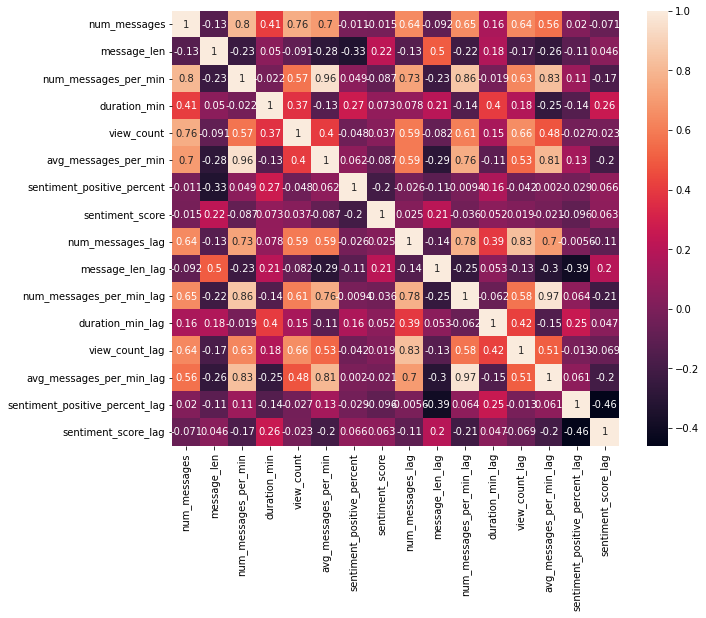

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))   
sns.heatmap(features_vid_df_lag.corr(), annot=True)

In [ ]:
!pip install linearmodels
!pip install stargazer

In [ ]:
# econometrics in python: https://medium.com/@vince.shields913/econometrics-with-python-pt-4-20b7842f01df
import statsmodels.formula.api as smf
from stargazer.stargazer import Stargazer
from IPython.core.display import HTML

fml = 'duration_min ~ num_messages + message_len + num_messages_per_min + sentiment_positive_percent +sentiment_score + np.log(view_count+1) '
reg1 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = 'duration_min ~ num_messages + message_len + num_messages_per_min + sentiment_positive_percent +sentiment_score + np.log(view_count+1) + duration_min_lag + num_messages_lag + message_len_lag + num_messages_per_min_lag '
reg2 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = 'duration_min ~ num_messages + message_len + num_messages_per_min + I(num_messages**2) + sentiment_positive_percent +sentiment_score + np.log(view_count+1) + duration_min_lag + num_messages_lag + message_len_lag + num_messages_per_min_lag '
reg3 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

stargazer = Stargazer([reg1, reg2,reg3])
HTML(stargazer.render_html())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 11, but rank is 10
  'rank is %d' % (J, J_), ValueWarning)


In [ ]:
# adding in quadratic terms
fml = 'duration_min ~ num_messages + message_len + num_messages_per_min +  avg_messages_per_min + I(num_messages**2) + sentiment_positive_percent +sentiment_score + np.log(view_count+1) + duration_min_lag + num_messages_lag + message_len_lag + num_messages_per_min_lag '
reg1 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = fml + '+ I(num_messages_per_min**2)'
reg2 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = fml + '+ I(avg_messages_per_min**2)'
reg3 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

stargazer = Stargazer([reg1, reg2,reg3])
HTML(stargazer.render_html())

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 12, but rank is 11
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 13, but rank is 12
  'rank is %d' % (J, J_), ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:1834: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 14, but rank is 13
  'rank is %d' % (J, J_), ValueWarning)


In [ ]:
# 'time_till_next_stream'
features_vid_df_lag['time_till_next_stream_in_min'] = features_vid_df_lag['time_till_next_stream'].dt.seconds/ 60
# 'time_till_next_stream'
fml = 'time_till_next_stream_in_min ~ num_messages + message_len + num_messages_per_min + sentiment_positive_percent +sentiment_score + np.log(view_count+1) '
reg1 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml =  fml + '+ avg_messages_per_min'
reg2 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml =  fml + '+ duration_min_lag + num_messages_lag + message_len_lag + num_messages_per_min_lag'
reg3 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = fml + '+ I(num_messages_per_min**2)'
reg4 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

fml = fml + '+ I(avg_messages_per_min**2)'
reg5 = smf.ols(formula= fml, data=features_vid_df_lag).fit(cov_type = 'HC3')

stargazer = Stargazer([reg1, reg2,reg3,reg4,reg5])
HTML(stargazer.render_html())

In [ ]:
features_vid_df_lag.columns

Index(['video_url', 'num_messages', 'message_len', 'video_id',
       'num_messages_per_min', 'user_id', 'duration_min', 'created_at',
       'title', 'view_count', 'broadcaster_type', 'broadcast_description',
       'broadcaster_created_at', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score', 'video_url_lag',
       'num_messages_lag', 'message_len_lag', 'video_id_lag',
       'num_messages_per_min_lag', 'user_id_lag', 'duration_min_lag',
       'created_at_lag', 'title_lag', 'view_count_lag', 'broadcaster_type_lag',
       'broadcast_description_lag', 'broadcaster_created_at_lag',
       'avg_messages_per_min_lag', 'sentiment_positive_percent_lag',
       'sentiment_score_lag', 'time_after_last_stream',
       'time_after_last_stream_end', 'user_id_post', 'created_at_post',
       'time_till_next_stream', 'time_till_last_stream_afterend',
       'time_till_next_stream_in_min'],
      dtype='object')

In [ ]:
# https://www.analyticsvidhya.com/blog/2020/03/what-is-multicollinearity/#:~:text=Multicollinearity%20occurs%20when%20two%20or,variable%20in%20a%20regression%20model.
# VIF exceeding 5 or 10 indicates high multicollinearity between this independent variable and the others
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif = pd.DataFrame()
variables = ['num_messages', 'message_len', 'num_messages_per_min', 'duration_min', 'view_count', 'avg_messages_per_min',
       'sentiment_positive_percent', 'sentiment_score', 'num_messages_lag', 'message_len_lag', 
       'num_messages_per_min_lag',  'duration_min_lag','view_count_lag', 'avg_messages_per_min_lag', 'sentiment_positive_percent_lag',
       'sentiment_score_lag', 'time_till_next_stream_in_min']
temp = features_vid_df_lag[variables].dropna()

vif["variables"] = temp.columns
vif["VIF"] = [variance_inflation_factor(temp.values, i) for i in range(temp.shape[1])]

vif

,variables,VIF
0,num_messages,9.274336
1,message_len,10.247977
2,num_messages_per_min,64.082819
3,duration_min,7.486068
4,view_count,6.346544
5,avg_messages_per_min,54.013397
6,sentiment_positive_percent,37.464267
7,sentiment_score,3563.164138
8,num_messages_lag,10.710744
9,message_len_lag,8.893999


So the signs are in cosistent with our intuition. Positive sentiment, good; More messages, good; But more messages per minute appearing like a waterfall, bad. Somehow the lagged variables aren't significant. 

In [ ]:
# create time index for panel regression
features_vid_df_lag['created_at'] = pd.to_datetime(features_vid_df_lag['created_at']) 
features_vid_df_lag['time'] = features_vid_df_lag['created_at'].dt.normalize()
features_vid_df_lag = features_vid_df_lag.set_index(["user_id", "time"], drop = False)

import linearmodels as plm
from linearmodels import PanelOLS

target = 'duration_min'
features = [ 'num_messages', 'message_len', 'num_messages_per_min','sentiment_positive_percent', 'sentiment_score','view_count']
reg1 = PanelOLS(features_vid_df_lag[target], features_vid_df_lag[features],  entity_effects=True).fit(cov_type='clustered', cluster_entity=True)

reg1.summary

Dep. Variable:,duration_min,R-squared:,0.6586
Estimator:,PanelOLS,R-squared (Between):,0.7524
No. Observations:,100,R-squared (Within):,0.6586
Date:,"Wed, Oct 26 2022",R-squared (Overall):,0.6931
Time:,22:29:39,Log-likelihood,-501.47
Cov. Estimator:,Clustered,,
,,F-statistic:,26.361
Entities:,12,P-value,0.0000
Avg Obs:,8.3333,Distribution:,"F(6,82)"
Min Obs:,2.0000,,
Max Obs:,15.000,F-statistic (robust):,85.344


In [ ]:
data_vid_df = pd.merge(chat_topic_df, video_df, how="left", left_on='video_id',right_on = 'id')
data_vid_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87 entries, 0 to 86
Data columns (total 33 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   video_url                      87 non-null     object 
 1   author_id                      87 non-null     int64  
 2   clean_messages_custom          87 non-null     object 
 3   topic0                         87 non-null     float64
 4   topic2                         87 non-null     float64
 5   topic3                         87 non-null     float64
 6   topic4                         87 non-null     float64
 7   topic5                         87 non-null     float64
 8   video_id                       87 non-null     object 
 9   Unnamed: 0                     87 non-null     object 
 10  id                             87 non-null     object 
 11  stream_id                      87 non-null     object 
 12  user_id                        87 non-null     objec

In [ ]:
# set index: https://www.geeksforgeeks.org/python-pandas-dataframe-set_index/
data_vid_df.set_index(["user_id", "video_id"], inplace = True,
                            append = True, drop = False)

In [ ]:
# sort: https://stackoverflow.com/questions/27842613/pandas-groupby-then-sort-within-groups
data_vid_df = data_vid_df.sort_values(['created_at'],ascending=False)
data_vid_df['created_at'].head()

    user_id    video_id  
86  552120296  1621692363    2022-10-11 22:59:51+00:00
85  40541068   1621583361    2022-10-11 20:34:34+00:00
84  32140000   1621428019    2022-10-11 17:22:34+00:00
83  32140000   1621315606    2022-10-11 14:39:14+00:00
82  32140000   1621305264    2022-10-11 14:20:53+00:00
Name: created_at, dtype: object

In [ ]:
data_vid_df.drop('column_name', axis=1, inplace=True)

In [ ]:
# create lag
shifted = data_vid_df.groupby(level="user_id").shift(-1)
data_vid_df_l = data_vid_df.join(shifted.rename(columns=lambda x: x+"_lag"))
data_vid_df_l.columns

Index(['video_url', 'author_id', 'clean_messages_custom', 'topic0', 'topic2',
       'topic3', 'topic4', 'topic5', 'video_id', 'Unnamed: 0', 'id',
       'stream_id', 'user_id', 'user_login', 'user_name', 'title',
       'description', 'created_at', 'published_at', 'url', 'thumbnail_url',
       'viewable', 'view_count', 'language', 'type', 'duration',
       'duration_min', 'broadcaster_type', 'broadcast_description',
       'broadcaster_profile_image_url', 'broadcaster_offline_image_url',
       'broadcaster_created_at', 'video_url_lag', 'author_id_lag',
       'clean_messages_custom_lag', 'topic0_lag', 'topic2_lag', 'topic3_lag',
       'topic4_lag', 'topic5_lag', 'video_id_lag', 'Unnamed: 0_lag', 'id_lag',
       'stream_id_lag', 'user_id_lag', 'user_login_lag', 'user_name_lag',
       'title_lag', 'description_lag', 'created_at_lag', 'published_at_lag',
       'url_lag', 'thumbnail_url_lag', 'viewable_lag', 'view_count_lag',
       'language_lag', 'type_lag', 'duration_lag', 'dura

In [ ]:
# check if lagged correctly
data_vid_df_l[['created_at','topic3','topic3_lag']].head()

,,,created_at,topic3,topic3_lag
,user_id,video_id,,,
86,552120296,1621692363,2022-10-11 22:59:51+00:00,0.855316,0.114866
85,40541068,1621583361,2022-10-11 20:34:34+00:00,0.000028,0.314840
84,32140000,1621428019,2022-10-11 17:22:34+00:00,0.000253,0.116679
83,32140000,1621315606,2022-10-11 14:39:14+00:00,0.116679,0.000232
82,32140000,1621305264,2022-10-11 14:20:53+00:00,0.000232,0.034143


In [ ]:
data_vid_df_l.to_csv('data_vid_df_l.csv')

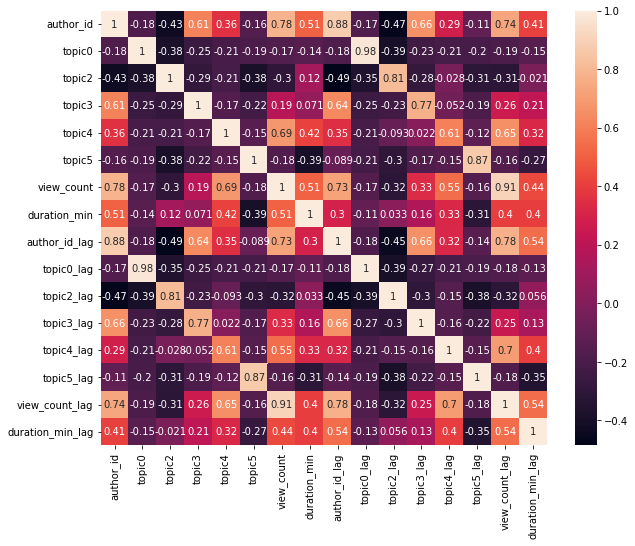

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,8))   
sns.heatmap(data_vid_df_l.corr(), annot=True)

In [ ]:
data_vid_df_l.describe()

,author_id,topic0,topic2,topic3,topic4,topic5,view_count,duration_min,author_id_lag,topic0_lag,topic2_lag,topic3_lag,topic4_lag,topic5_lag,view_count_lag,duration_min_lag
count,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,87.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000,76.000000
mean,4515.310345,0.151953,0.408954,0.174852,0.124855,0.139386,44381.574713,103.564176,4469.065789,0.157137,0.410393,0.181701,0.111283,0.139486,42693.671053,96.249342
std,6968.373182,0.326716,0.377980,0.298618,0.240281,0.307101,105617.152487,78.314531,7109.227002,0.332721,0.375262,0.305472,0.221043,0.309484,99916.897187,75.052281
min,1.000000,0.000007,0.000007,0.000028,0.000008,0.000007,0.000000,0.333333,1.000000,0.000007,0.000007,0.000045,0.000008,0.000007,0.000000,0.333333
25%,121.500000,0.000136,0.000153,0.000395,0.001336,0.000053,33.000000,25.983333,102.500000,0.000141,0.000120,0.000509,0.000857,0.000055,31.750000,23.475000
50%,1293.000000,0.002762,0.510525,0.039759,0.014168,0.000458,279.000000,88.600000,1232.500000,0.002773,0.516698,0.036951,0.013270,0.000854,313.500000,82.075000
75%,4280.500000,0.069780,0.758154,0.198209,0.135574,0.013736,15235.500000,166.700000,3769.000000,0.070984,0.747769,0.198866,0.119186,0.013587,17263.500000,151.800000
max,20000.000000,0.999795,0.999746,0.999967,0.952449,0.999629,474421.000000,238.733333,20000.000000,0.999795,0.999746,0.999967,0.952449,0.999629,474421.000000,238.733333


### 